In [1]:
!nvidia-smi

Fri Apr 23 23:30:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8    10W /  N/A |    592MiB /  5934MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [3]:
import pickle # 
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from KD_Lib.KD import DML, VirtualTeacher, SelfTraining, ProbShift, LabelSmoothReg, RCO

In [5]:
data = pd.read_csv('data/UNSW_NB15_training-set.csv')
data.head()

,id,dur,xProt,xServ,xState,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.121478,4,999,2,6,4,258,172,74.087490,...,1,1,1,0,0,0,1,1,0,0
1,2,0.649902,4,999,2,14,38,734,42014,78.473372,...,1,1,2,0,0,0,1,6,0,0
2,3,1.623129,4,999,2,8,16,364,13186,14.170161,...,1,1,3,0,0,0,2,6,0,0
3,4,1.681642,4,3,2,12,12,628,770,13.677108,...,1,1,3,1,1,0,2,1,0,0
4,5,0.449454,4,999,2,10,6,534,268,33.373826,...,2,1,40,0,0,0,2,39,0,0


In [6]:
X = data.iloc[: , :-1].values
X.shape

(175341, 43)

In [7]:
attacks = list(pd.unique(data["label"]))
attacks

[0, 1]

In [8]:
y = np.array(list(map((lambda x: attacks.index(x)), data.iloc[: , -1].values)))
y.shape

(175341,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, y_train.shape, y_test.shape

((140272, 43), (140272,), (140272,), (35069,))

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

------------------------------------------------------------------------------------------------------------------

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [12]:
class UNSWDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [13]:
train_data = UNSWDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_data = UNSWDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

In [14]:
bs = 256

train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=bs)

In [15]:
len(train_loader.dataset)//bs + 1, len(test_loader.dataset)//bs + 1

(548, 137)

In [16]:
class Teacher(nn.Module):

    def __init__(self, n_features, n_classes):
        super(Teacher, self).__init__()

        self.mlp = nn.Sequential(*[
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes)
        ])

    def forward(self, x):
        return self.mlp(x)

In [17]:
class Student(nn.Module):

    def __init__(self, n_features, n_classes):
        super(Student, self).__init__()

        self.mlp = nn.Sequential(*[
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, n_classes)
        ])

    def forward(self, x):
        return self.mlp(x)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Self Training

In [19]:
teacher = Teacher(X_train.shape[1], len(attacks)).to(device)
teacher_optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9)

student = Student(X_train.shape[1], len(attacks)).to(device)
student_optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9)


Training self teacher...
Epoch: 1, Loss: 155.10986328125, Accuracy: 0.8789922436409262
Epoch: 2, Loss: 75.94918823242188, Accuracy: 0.9379277403900992
Epoch: 3, Loss: 67.2199935913086, Accuracy: 0.9453205201323144
Epoch: 4, Loss: 63.91858673095703, Accuracy: 0.9485713470970686
Epoch: 5, Loss: 62.343505859375, Accuracy: 0.9493555378122505
Epoch: 6, Loss: 61.59968566894531, Accuracy: 0.9497618911828447
Epoch: 7, Loss: 60.19198989868164, Accuracy: 0.951487110756245
Epoch: 8, Loss: 58.70058822631836, Accuracy: 0.9530768792061138
Epoch: 9, Loss: 56.5797119140625, Accuracy: 0.955978384852287
Epoch: 10, Loss: 54.712398529052734, Accuracy: 0.958202634880803
Epoch: 11, Loss: 53.069236755371094, Accuracy: 0.9609686894034447
Epoch: 12, Loss: 51.51377487182617, Accuracy: 0.9625655868598152
Epoch: 13, Loss: 49.59995651245117, Accuracy: 0.9642765484202122
Epoch: 14, Loss: 47.99673080444336, Accuracy: 0.9658734458765826
Epoch: 15, Loss: 47.18315887451172, Accuracy: 0.9660017679936124
Epoch: 16, Loss

/home/neelay/miniconda3/envs/ap/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 1, Loss: 78.87763977050781, Accuracy: 0.9195919356678454
Epoch: 2, Loss: 65.5887222290039, Accuracy: 0.9445577164366374
Epoch: 3, Loss: 63.915504455566406, Accuracy: 0.9493127637732406
Epoch: 4, Loss: 60.576541900634766, Accuracy: 0.9605266910003422
Epoch: 5, Loss: 58.61293411254883, Accuracy: 0.9648326109273412
Epoch: 6, Loss: 57.63764572143555, Accuracy: 0.9668216037413027
Epoch: 7, Loss: 57.414283752441406, Accuracy: 0.9672992471769134
Epoch: 8, Loss: 57.108306884765625, Accuracy: 0.9678766967035474
Epoch: 9, Loss: 56.62388229370117, Accuracy: 0.969409433101403
Epoch: 10, Loss: 56.012935638427734, Accuracy: 0.9708138473822289
Epoch: 11, Loss: 55.656768798828125, Accuracy: 0.9711845557203148
Epoch: 12, Loss: 55.113868713378906, Accuracy: 0.9724535188776092
Epoch: 13, Loss: 55.02373123168945, Accuracy: 0.9729169043002167
Epoch: 14, Loss: 54.865840911865234, Accuracy: 0.9731592905212729
Epoch: 15, Loss: 54.5311279296875, Accuracy: 0.9741217063989962
Epoch: 16, Loss: 54.518146514

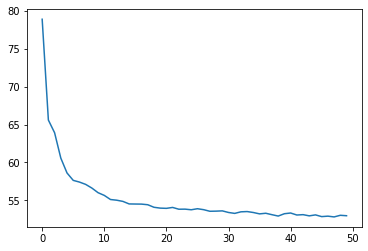

In [20]:
distiller = SelfTraining(student, train_loader, test_loader, student_optimizer,
                         device=device)
distiller.train_student(epochs=50, save_model=False)                                      

In [21]:
distiller.evaluate()        

--------------------------------------------------------------------------------
Accuracy: 0.9761612820439705


# Probability Shift

In [22]:
teacher = Teacher(X_train.shape[1], len(attacks)).to(device)
teacher_optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9)

student = Student(X_train.shape[1], len(attacks)).to(device)
student_optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9)

Training Teacher... 
Epoch: 1, Loss: 83.67657470703125, Accuracy: 0.9335719174175887
Epoch: 2, Loss: 52.8486328125, Accuracy: 0.9605979810653588
Epoch: 3, Loss: 43.801597595214844, Accuracy: 0.966750313676286
Epoch: 4, Loss: 41.41749954223633, Accuracy: 0.9688890156267822
Epoch: 5, Loss: 38.76234817504883, Accuracy: 0.9705572031481693
Epoch: 6, Loss: 38.300392150878906, Accuracy: 0.9706783962586973
Epoch: 7, Loss: 37.32029724121094, Accuracy: 0.9714126839283678
Epoch: 8, Loss: 34.801673889160156, Accuracy: 0.9733375156838143
Epoch: 9, Loss: 35.4350471496582, Accuracy: 0.9731307744952663
Epoch: 10, Loss: 34.6246223449707, Accuracy: 0.9732305805862895
Epoch: 11, Loss: 33.486690521240234, Accuracy: 0.9743569636135508
Epoch: 12, Loss: 33.46706771850586, Accuracy: 0.974806091023155
Epoch: 13, Loss: 32.47420120239258, Accuracy: 0.975568894718832
Epoch: 14, Loss: 32.58771896362305, Accuracy: 0.9753550245237823
Epoch: 15, Loss: 32.40342330932617, Accuracy: 0.9753478955172807
Epoch: 16, Loss: 3

0.9710285437280789

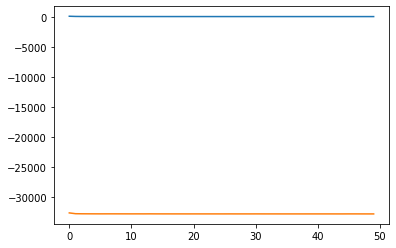

In [23]:
distiller = ProbShift(teacher, student, train_loader, test_loader, teacher_optimizer,
                      student_optimizer, device=device, temp=10)
distiller.train_teacher(epochs=50)                                       # Train the teacher model
distiller.train_student(epochs=50)                                      # Train the student model
distiller.evaluate(teacher=True)                                        # Evaluate the teacher model
distiller.evaluate()   

# Label Smoothening Regularization

In [24]:
teacher = Teacher(X_train.shape[1], len(attacks)).to(device)
teacher_optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9)

student = Student(X_train.shape[1], len(attacks)).to(device)
student_optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9)

Training Teacher... 
Epoch: 1, Loss: 85.24127197265625, Accuracy: 0.9327164366373902
Epoch: 2, Loss: 52.13734817504883, Accuracy: 0.9625869738793201
Epoch: 3, Loss: 46.492305755615234, Accuracy: 0.9660588000456256
Epoch: 4, Loss: 42.04857635498047, Accuracy: 0.968810596555264
Epoch: 5, Loss: 38.8761100769043, Accuracy: 0.97103484658378
Epoch: 6, Loss: 37.431819915771484, Accuracy: 0.9715837800844075
Epoch: 7, Loss: 36.56076431274414, Accuracy: 0.9727172921181704
Epoch: 8, Loss: 35.497493743896484, Accuracy: 0.9734159347553325
Epoch: 9, Loss: 34.86281967163086, Accuracy: 0.9735157408463556
Epoch: 10, Loss: 34.45140075683594, Accuracy: 0.9739506102429566
Epoch: 11, Loss: 34.03718566894531, Accuracy: 0.9735371278658607
Epoch: 12, Loss: 33.3963623046875, Accuracy: 0.973693966008897
Epoch: 13, Loss: 33.34670639038086, Accuracy: 0.974435382685069
Epoch: 14, Loss: 32.361900329589844, Accuracy: 0.9748916391011748
Epoch: 15, Loss: 32.3203010559082, Accuracy: 0.9747276719516368
Epoch: 16, Loss: 

0.9028771849781858

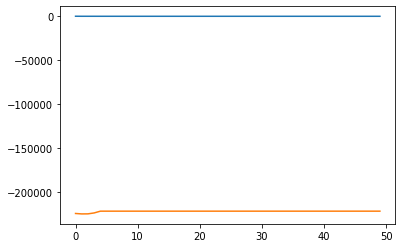

In [25]:
distiller = LabelSmoothReg(teacher, student, train_loader, test_loader, teacher_optimizer,
                           student_optimizer, correct_prob=0.9, device=device)
distiller.train_teacher(epochs=50, save_model=False)                                       # Train the teacher model
distiller.train_student(epochs=50, save_model=False)                                      # Train the student model
distiller.evaluate(teacher=True)                                        # Evaluate the teacher model
distiller.evaluate()                                                    # Evaluate the student model

# Deep Mutual Learning

In [26]:
student_model_1 = Student(X_train.shape[1], len(attacks)).to(device)
student_model_2 = Student(X_train.shape[1], len(attacks)).to(device)
student_model_3 = Student(X_train.shape[1], len(attacks)).to(device)

student_cohort = (student_model_1, student_model_2, student_model_3)

student_optimizer_1 = optim.SGD(student_model_1.parameters(), lr=0.1, momentum=0.9)
student_optimizer_2 = optim.SGD(student_model_2.parameters(), lr=0.1, momentum=0.9)
student_optimizer_3 = optim.SGD(student_model_3.parameters(), lr=0.1, momentum=0.9)

optimizers = [student_optimizer_1, student_optimizer_2, student_optimizer_3]


Training students...
Epoch: 1, Loss: nan, Accuracy: 0.9259652674803239
Epoch: 2, Loss: nan, Accuracy: 0.9592862438690544
Epoch: 3, Loss: nan, Accuracy: 0.9642694194137105
Epoch: 4, Loss: nan, Accuracy: 0.966793087715296
Epoch: 5, Loss: nan, Accuracy: 0.9677555035930193
--------------------------------------------------------------------------------
Evaluating student 0
Accuracy: 0.9668653226496335
--------------------------------------------------------------------------------
Evaluating student 1
Accuracy: 0.3184864125010693
--------------------------------------------------------------------------------
Evaluating student 2
Accuracy: 0.3184864125010693


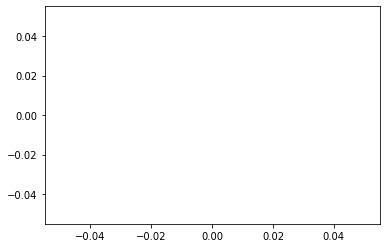

In [27]:
distiller = DML(student_cohort, train_loader, test_loader, optimizers, loss_fn=nn.KLDivLoss(),
                device=device)
distiller.train_students(epochs=5, plot_losses=True, save_model=False)   # Train the student cohort
distiller.evaluate()        

# Route Contrained Optimization

In [28]:
teacher = Teacher(X_train.shape[1], len(attacks)).to(device)
teacher_optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9)

student = Student(X_train.shape[1], len(attacks)).to(device)
student_optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9)

Training Teacher... 
Epoch: 1, Loss: 79.90705108642578, Accuracy: 0.9364163910117486
Epoch: 2, Loss: 50.67529296875, Accuracy: 0.9640341621991559
Epoch: 3, Loss: 43.8865852355957, Accuracy: 0.9680192768335805
Epoch: 4, Loss: 41.20234298706055, Accuracy: 0.9696375613094559
Epoch: 5, Loss: 39.443912506103516, Accuracy: 0.9704431390441428
Epoch: 6, Loss: 38.27216720581055, Accuracy: 0.9710704916162883
Epoch: 7, Loss: 36.65374755859375, Accuracy: 0.9722396486825596
Epoch: 8, Loss: 35.82228088378906, Accuracy: 0.9724891639101175
Epoch: 9, Loss: 35.71868133544922, Accuracy: 0.9728170982091936
Epoch: 10, Loss: 34.86296081542969, Accuracy: 0.973116516482263
Epoch: 11, Loss: 33.98298645019531, Accuracy: 0.9739078362039466
Epoch: 12, Loss: 33.771522521972656, Accuracy: 0.974228641496521
Epoch: 13, Loss: 33.57965850830078, Accuracy: 0.9740931903729896
Epoch: 14, Loss: 31.736587524414062, Accuracy: 0.9757186038553667
Epoch: 15, Loss: 31.814231872558594, Accuracy: 0.9752979924717692
Epoch: 16, Loss

0.9255467792067068

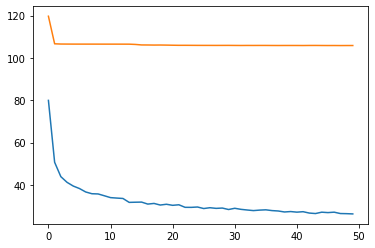

In [29]:
distiller = RCO(teacher, student, train_loader, test_loader, teacher_optimizer,
                student_optimizer, epoch_interval=5, device=device)
distiller.train_teacher(epochs=50, save_model=False)                                      # Train the teacher model
distiller.train_student(epochs=50, save_model=False)                                     # Train the student model
distiller.evaluate(teacher=True)                                        # Evaluate the teacher model
distiller.evaluate()                                                    # Evaluate the student model